In [9]:
import matplotlib.pyplot as plt
from teyssier import weno, cons_to_prim
from teyssier.sedov import sedovana
import numpy as np
from superfv.euler_solver import EulerSolver
from superfv.initial_conditions import sedov
from functools import partial

In [10]:
dim = 1
gamma = 1.4
E0 = 1
rho0 = 1
T = 0.8

r, d, u, P = sedovana(gamma, dim)

r *= (E0 / rho0) ** (1.0 / (dim + 2)) * T ** (2 / (dim + 2))
d *= rho0
u *= (E0 / rho0) ** (1.0 / (dim + 2)) * T ** (-dim / (dim + 2))
P *= (E0 / rho0) ** (2.0 / (dim + 2)) * T ** (-2 * dim / (dim + 2)) * rho0

chi0=np.float64(0.97306051566207)


In [11]:
N = 128
p = 3
CFL = 0.8
riemann_solver = "hllc"

sim_a_priori = EulerSolver(
    ic=partial(sedov, gamma=gamma, h=1 / N),
    bcx=("reflective", "free"),
    riemann_solver=riemann_solver,
    CFL=CFL,
    gamma=gamma,
    nx=N,
    p=p,
    flux_recipe=3,
    lazy_primitives=True,
    ZS=True,
    adaptive_timestepping=False,
)
sim_a_priori.run(T, allow_overshoot=True)

sim_a_posteriori = EulerSolver(
    ic=partial(sedov, gamma=gamma, h=1 / N),
    bcx=("reflective", "free"),
    riemann_solver=riemann_solver,
    CFL=CFL,
    gamma=gamma,
    nx=N,
    p=p,
    flux_recipe=3,
    lazy_primitives=True,
    MOOD=True,
    NAD=1e-2,
    limiting_vars=("rho", "P"),
)
sim_a_posteriori.run(T, allow_overshoot=True)

_, u_teyssier = weno(
    ic_type="sedov",
    bc_type="sedov",
    riemann_solver=riemann_solver,
    cfl=CFL,
    n=N,
    time=p + 1,
    space=p + 1,
    tend=T,
)

# convert Teyssier solution to primitive variables
x = (np.arange(u_teyssier.shape[2]) + 0.5) / u_teyssier.shape[2]
wt = cons_to_prim(u_teyssier[-1, :, :])

100%|█████████▉| 0.7987808805401657/0.8 [00:03]   /Users/jonathan/miniconda3/envs/superfv/lib/python3.12/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 0.8007985826359786/0.8 [00:03]/Users/jonathan/miniconda3/envs/superfv/lib/python3.12/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 0.8007985826359786/0.8 [00:03]
100%|█████████▉| 0.7982166398925401/0.8 [00:04]   /Users/jonathan/miniconda3/envs/superfv/lib/python3.12/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 0.8001970833491721/0.8 [00:04]/Users/jonathan/miniconda3/envs/superfv/lib/python3.12/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 0.8001970833491721/0.8 [00:04]
/Users/jonathan/Desktop/superfv/teyssier/riemann.py:241: RuntimeWarning: invalid value encountered in 

cell= 128  itermax= 100000


/Users/jonathan/Desktop/superfv/teyssier/riemann.py:242: RuntimeWarning: invalid value encountered in divide
  pstar = (dcl * pr + dcr * pl + dcl * dcr * (vl - vr)) / (dcl + dcr)
/Users/jonathan/Desktop/superfv/teyssier/riemann.py:244: RuntimeWarning: divide by zero encountered in divide
  dstarl = dl * (sl - vl) / (sl - vstar)
/Users/jonathan/Desktop/superfv/teyssier/riemann.py:246: RuntimeWarning: invalid value encountered in divide
  estarl = ((sl - vl) * el - pl * vl + pstar * vstar) / (sl - vstar)
/Users/jonathan/Desktop/superfv/teyssier/riemann.py:241: RuntimeWarning: invalid value encountered in divide
  vstar = (dcl * vl + dcr * vr + pl - pr) / (dcl + dcr)
/Users/jonathan/Desktop/superfv/teyssier/riemann.py:242: RuntimeWarning: invalid value encountered in divide
  pstar = (dcl * pr + dcr * pl + dcl * dcr * (vl - vr)) / (dcl + dcr)
/Users/jonathan/Desktop/superfv/teyssier/riemann.py:244: RuntimeWarning: divide by zero encountered in divide
  dstarl = dl * (sl - vl) / (sl - vsta

Done  434 0.8020339138264351


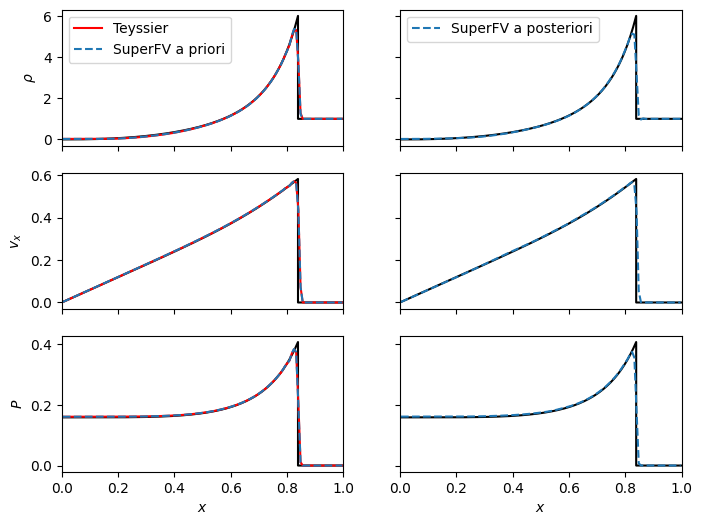

In [12]:
fig, axs = plt.subplots(3, 2, sharex=True, sharey="row", figsize=(8, 6))

# rho
axs[0, 0].set_ylabel(r"$\rho$")
axs[0, 0].plot(r, d, color="k")
axs[0, 1].plot(r, d, color="k")
axs[0, 0].plot(
    x, wt[0, :], marker="none", mfc="none", linestyle="-", label=r"Teyssier", color="r"
)
sim_a_priori.plot_1d_slice(
    axs[0, 0],
    "rho",
    array="w",
    x=None,
    marker="none",
    mfc="none",
    linestyle="--",
    label=r"SuperFV a priori",
)
sim_a_posteriori.plot_1d_slice(
    axs[0, 1],
    "rho",
    array="w",
    x=None,
    marker="none",
    mfc="none",
    linestyle="--",
    label=r"SuperFV a posteriori",
)

# vx
axs[1, 0].set_ylabel(r"$v_x$")
axs[1, 0].plot(r, u, color="k")
axs[1, 1].plot(r, u, color="k")
axs[1, 0].plot(
    x, wt[1, :], marker="none", mfc="none", linestyle="-", label=r"Teyssier", color="r"
)
sim_a_priori.plot_1d_slice(
    axs[1, 0],
    "vx",
    array="w",
    x=None,
    marker="none",
    mfc="none",
    linestyle="--",
    label=r"SuperFV a priori",
)
sim_a_posteriori.plot_1d_slice(
    axs[1, 1],
    "vx",
    array="w",
    x=None,
    marker="none",
    mfc="none",
    linestyle="--",
    label=r"SuperFV a posteriori",
)

# P
axs[2, 0].set_ylabel(r"$P$")
axs[2, 0].plot(r, P, color="k")
axs[2, 1].plot(r, P, color="k")
axs[2, 0].plot(
    x, wt[2, :], marker="none", mfc="none", linestyle="-", label=r"Teyssier", color="r"
)
sim_a_priori.plot_1d_slice(
    axs[2, 0],
    "P",
    array="w",
    x=None,
    marker="none",
    mfc="none",
    linestyle="--",
    label=r"SuperFV a priori",
    xlabel=True,
)
sim_a_posteriori.plot_1d_slice(
    axs[2, 1],
    "P",
    array="w",
    x=None,
    marker="none",
    mfc="none",
    linestyle="--",
    label=r"SuperFV a posteriori",
    xlabel=True,
)

axs[2, 0].set_xlim(0, 1)
axs[2, 1].set_xlim(0, 1)
axs[0, 0].legend()
axs[0, 1].legend()